<a href="https://colab.research.google.com/github/gwkennedyiii/Algorithmic-Trading-Workbook/blob/main/O'Reilly_Class_Algorithmic_Capital_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Code in this notebook is based on Chapter 13, "Python for Finance, 2nd Edition" by Yves Hilpisch***

In [ ]:
#Import necessary libraries
import scipy.stats as scs
import numpy as np
import numpy.random as npr
import pandas_datareader.data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

# Modern Portfolio Theory

In [ ]:
#Download data from Yahoo Finance
start = datetime(2017, 7, 16)
end = datetime(2021, 5, 11)
symbols = ['TLT', 'VEU', 'SPY', 'GLD'] #TLT bond index; VEU is all world index ex US; GLD - gold index;
data = pdr.get_data_yahoo(symbols, start, end)

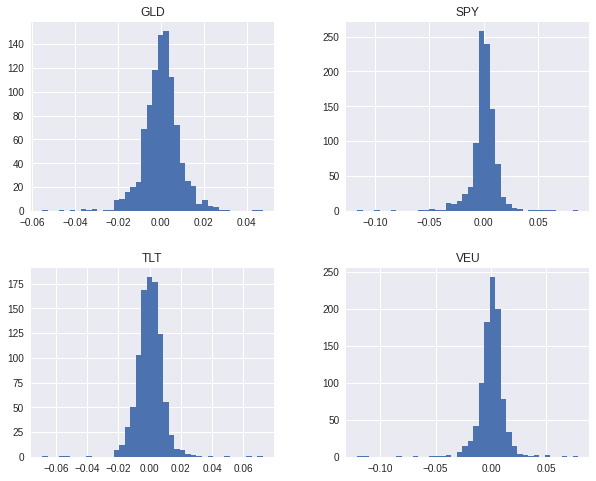

In [ ]:
#Calculate daily log returns and plot the histogram
rets = np.log(data['Adj Close']/data['Adj Close'].shift(1))
rets.hist(bins=40, figsize = (10, 8));

In [ ]:
#Annualize mean returns
rets.mean()* 252

GLD    0.100665
SPY    0.157845
TLT    0.050101
VEU    0.082702
dtype: float64

In [ ]:
#Compute the annualized covariance matrix 
rets.cov() * 252 #Covariance of an asset with itself is its variance (i.e. the square of its standard deviation or volatility)

,GLD,SPY,TLT,VEU
GLD,0.019438,0.001902,0.005532,0.003925
SPY,0.001902,0.043859,-0.012101,0.037313
TLT,0.005532,-0.012101,0.020948,-0.010323
VEU,0.003925,0.037313,-0.010323,0.038651


In [ ]:
noa = len(symbols)
#Generate random weights
weights = npr.random(noa)
#Normalize the weights so that they add up to 1
weights /= np.sum(weights)
print(weights)
weights.sum()

[0.12540612 0.10493223 0.03133347 0.73832818]


1.0

In [ ]:
#Calculate annualized weighted returns 
print(np.sum(rets.mean() * weights) *252)
#Compute annualized weighted volatility using dot product of weights and covariance matrix
variance = np.dot(weights.T, np.dot(rets.cov()*252, weights))
print(np.sqrt(variance))

0.09181842209014791
0.1671029002239406


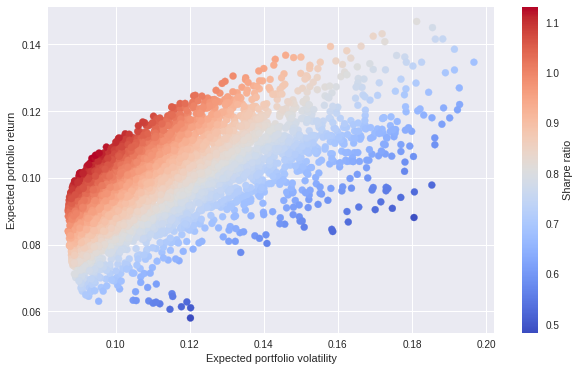

In [ ]:
#Function returns portfolio's weighted annualized return
def port_ret(weights):
  return np.sum(rets.mean() * weights) * 252

#Function returns portfolio's weighted annualized volatitily
def port_vol(weights):
  return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

prets = []
pvols = []

#Monte Carlo simulation of portfolio weights
for p in range (5000):
  weights = np.random.random(noa)
  weights /= np.sum(weights)
  #Collect statistics in list object
  prets.append(port_ret(weights))
  pvols.append(port_vol(weights))

prets = np.array(prets)
pvols = np.array(pvols)

#Plot the expected portfolio returns versus volatility
plt.figure(figsize = (10, 6))
plt.scatter(pvols, prets, c=prets/pvols, marker = 'o', cmap = 'coolwarm')
plt.xlabel('Expected portfolio volatility')
plt.ylabel('Expected portolio return')
plt.colorbar(label = 'Sharpe ratio');


# Kelly Criterion

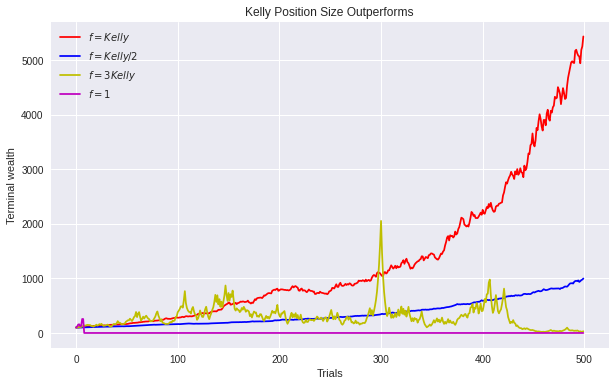

In [ ]:
np.random.seed(101)
#Weighted coin in your favor
probability = 0.55
#The Kelly position size (edge/odds) for odds 1:1
kelly = probability - (1-probability)

#Number of series in Monte Carlo simulation
I = 50
#Number of trials per series
n = 500

def run_simulation (kelly):
  #Array for storing results 
  c = np.zeros((n, I))
  #Initial capital of $100
  c[0] = 100
  for i in range(I):
      for t in range(1, n):
        #Use binomial random variable because we are tossing a weighted coin
        outcome = np.random.binomial(1, probability)
        if outcome > 0:
          #If we win, we add the kelly fraction to our accumalated capital
          c[t, i] = (1 + kelly) * c[t-1, i]
        else:
          #If we lose, we subtract the kelly fraction from our accumulated capital
          c[t, i] = (1 - kelly) * c[t-1, i]
  return c

#Run simulations for different position sizes
#The kelly position size is our optimal betting size 
c_1 = run_simulation(kelly)
#Half kelly size reduces the volatility while keeping the gains
c_2 = run_simulation(kelly/2)
#Anything more than twice Kelly leads to ruin in the long run
c_3 = run_simulation(kelly*3)
#Betting all your capital leads to ruin very quickly
c_4 = run_simulation(1)

#Plot the expected value/arithmetic mean of terminal wealth over all the iterations of 500 trials each
plt.figure(figsize=(10, 6))         
plt.plot(c_1.mean(axis=1), 'r', label='$f=Kelly$')         
plt.plot(c_2.mean(axis=1), 'b', label='$f=Kelly/2$')         
plt.plot(c_3.mean(axis=1), 'y', label='$f=3Kelly$')         
plt.plot(c_4.mean(axis=1), 'm', label='$f=1$')
plt.legend(loc=0), plt.title('Kelly Position Size Outperforms'), plt.ylabel('Terminal wealth'), plt.xlabel('Trials');
   